In [134]:
from processing.DataLoader import DataLoaderFactory
from processing.AlignerBuilder import *
from processing.Optimizer import *

In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Generación aleatoria de secuencias de aminoácidos

Lo primero que hacemos es generar automáticamente dos secuencias aleatorias de aminoácidos de longitudes 70 y 65. Estas secuencias se generan a partir de una lista de aminoácidos predefinida, y se escoge aleatoriamente un aminoácido de la lista para cada posición de la secuencia.

In [136]:
sequenceLoader = DataLoaderFactory.get_loader("random")

In [137]:
sequence1 = sequenceLoader.load(50)
sequence2 = sequenceLoader.load(50)

print(f"Sequence 1: {sequence1}")
print(f"Sequence 2: {sequence2}")

Sequence 1: CEVGESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Sequence 2: QTCEYWSVIDFSSETCHFNMDWARHKDGWYSVNKEGWQRWYHSYMIQHLA


### Alineamiento de secuencias con ajuste manual

A continuación, generamos un alineador de secuencias, asignándole algunos valores de penalización y recompensa para la función de alineamiento. Luego, alineamos las dos secuencias generadas anteriormente y mostramos el resultado.

In [138]:
aligner = AlignerBuilder().build(
                                AlignerArgs(
                                    match_score=3,
                                    mismatch_score=-1,
                                    target_internal_extend_gap_score=-3,
                                    target_internal_open_gap_score=-5
                                )
                            )

In [139]:
print(aligner.args())

AlignerArgs(match_score=3.0, 
                    mismatch_score=-1.0, 
                    target_internal_open_gap_score=-5.0, 
                    target_internal_extend_gap_score=-3.0, 
                    target_left_open_gap_score=0.0, 
                    target_left_extend_gap_score=0.0, 
                    target_right_open_gap_score=0.0, 
                    target_right_extend_gap_score=0.0, 
                    query_internal_open_gap_score=0.0, 
                    query_internal_extend_gap_score=0.0, 
                    query_left_open_gap_score=0.0, 
                    query_left_extend_gap_score=0.0, 
                    query_right_open_gap_score=0.0, 
                    query_right_extend_gap_score=0.0)


In [140]:
alignments = aligner.align(sequence1, sequence2)

In [141]:
def get_matches(alignment):
    matches = 0
    seq1 = alignment[0]
    seq2 = alignment[1]

    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            matches += 1

    return matches

In [142]:
matches = []
scores = []

for i, alignment in enumerate(alignments):
    matches.append(get_matches(alignment))
    scores.append(alignment.score)
    print(f"Alignment {i}: Matches: {matches[-1]} - Score: {scores[-1]}")
    print(f"Alignment {i}: {alignment[0]}\nAlignment {i}: {alignment[1]}\n\n")
    
    if i >= 10:
        break

Alignment 0: Matches: 11 - Score: 30.0
Alignment 0: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 0: G-WYS-V-------NK-------------E----G---WQ---RW-Y


Alignment 1: Matches: 11 - Score: 30.0
Alignment 1: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 1: GW-YS-V-------NK-------------E----G---WQ---RW-Y


Alignment 2: Matches: 11 - Score: 30.0
Alignment 2: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 2: GWY-S-V-------NK-------------E----G---WQ---RW-Y


Alignment 3: Matches: 11 - Score: 30.0
Alignment 3: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 3: G-WYS-V-------NK-------------E----G---WQ--R-W-Y


Alignment 4: Matches: 11 - Score: 30.0
Alignment 4: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 4: GW-YS-V-------NK-------------E----G---WQ--R-W-Y


Alignment 5: Matches: 11 - Score: 30.0
Alignment 5: GESTSHVHSIIESWNKNAMMGVMLQCQVAETYHFGTQSWQCFLEWPY
Alignment 5: GWY-S-V-------NK-------------E----G---WQ--R-W-Y


Alignment 6: Matches: 

Se consigue un alineamiento con un score de 24, con un total de 9 coincidencias.

### Alineamiento de secuencias con algoritmo genético

Un algoritmo genético es un algoritmo de optimización que simula el proceso de evolución natural para encontrar la mejor solución a un problema. En ellos, se define una población inicial de posibles soluciones (individuos), que son representadas generalmente como cadenas de genes (normalmente en forma binaria o como arreglos de valores). Cada individuo en la población tiene un nivel de desempeño medido por una función de aptitud (fitness), que evalúa qué tan buena es la solución representada por ese individuo en relación con el problema que se desea resolver.

El algoritmo opera mediante operadores genéticos, que incluyen la selección, donde los individuos más aptos tienen mayor probabilidad de reproducirse; el cruce (crossover), que combina genes de dos individuos para generar nuevos individuos (descendencia); y la mutación, que introduce cambios aleatorios en los genes para mantener la diversidad genética y explorar nuevas áreas del espacio de búsqueda. Este proceso se repite durante un número fijo de generaciones o hasta que se cumple un criterio de convergencia, con el objetivo de que las soluciones evolucionen hacia un máximo (o mínimo) en la función de aptitud. Los algoritmos genéticos son especialmente útiles para resolver problemas complejos de optimización en los que el espacio de búsqueda es muy grande o no está bien definido.

In [143]:
from processing.Optimizer import *

A continuación, aplicaremos dichos algoritmos, con el objetivo de encontrar la combinación de valores de penalización y recompensa que maximicen el score alcanzado en el alineamiento de las dos secuencias generadas anteriormente. Para ello, definimos una función de fitness que devuelve, para cada alineamiento, el número de coincidencias obtenidas.

In [144]:
def fitness_function(aligner):
    matches = 0
    
    alignment = aligner.align(sequence1, sequence2)[0]
    seq1 = alignment[0]
    seq2 = alignment[1]

    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            matches += 1

    return matches

Ahora sí, dejaremos al algoritmo desarrollarse durante 5 iteraciones, con poblaciones de 1200 individuos, que en este problema representan combinaciones de valores de penalización y recompensa. Al final, mostraremos el mejor alineamiento encontrado, con un score de 24 y 9 coincidencias, igual al obtenido manualmente.

In [251]:
geneticAlgorithm = GeneticAlgorithm(1200, 5, sequence1, sequence2, fitness_function)
aligners, best_aligner = geneticAlgorithm.run()

In [252]:
print(f"Best aligner: {best_aligner.args()}")

Best aligner: AlignerArgs(match_score=9.948647681109431, 
                    mismatch_score=-9.533337651215863, 
                    target_internal_open_gap_score=-0.5626935077836481, 
                    target_internal_extend_gap_score=-1.3224425395624184, 
                    target_left_open_gap_score=-6.51439919407234, 
                    target_left_extend_gap_score=-6.198810320244487, 
                    target_right_open_gap_score=-8.45221923577287, 
                    target_right_extend_gap_score=-1.9226450171121012, 
                    query_internal_open_gap_score=-7.728482601267625, 
                    query_internal_extend_gap_score=-1.1109554998452031, 
                    query_left_open_gap_score=-3.790308498217315, 
                    query_left_extend_gap_score=-0.10826586286379447, 
                    query_right_open_gap_score=-7.031120693617138, 
                    query_right_extend_gap_score=-3.4951787092206086)


El alineador obtenido con el algoritmo genético tiene los siguientes valores de puntuación:

In [253]:
alignments = best_aligner.align(sequence1, sequence2)

for i, alignment in enumerate(alignments):
    print(f"Matches: {get_matches(alignment)} - Score: {alignment.score}")
    print(f"{alignment[0]}\n{alignment[1]}\n\n")
    
    if i >= 10:
        break

Matches: 40 - Score: 122.50782387273354
E--EK-----S-A--V-T--A-LWG--KV-N--V---D---E--VGG-E--A------LGRL---LVVYPWTQRFFESFGDLSTPDAVMGNPKV-KA-H-GKKV-L-GA-FSD-G-L---AH-LDNL-K-----GT-F---ATLSELH-----C--D-KLHVDPENF
EGVEKLMDIF-YAKI-RTHE-QL-GPI--FNGAVGIDDASWERH---KEKIAKFWKTML--LNENL--Y-------------------MGNP-VQ--PHI----NLL--PF-DI-KLFDV--WLD-LFKECLDQ--VFEEKA--SE-HFYEVACNI-AK------NF




A continuación, representamos los resultados obtenidos en la última iteración del algoritmo genético, mostrando, entre otras, los valores de score obtenidos para la población de individuos final.

In [254]:
match_scores = []
matches = []
mismatch_scores = []
open_gap_scores = []
extend_gap_scores = []
scores = []

for aligner in aligners:
    alignment = aligner.align(sequence1, sequence2)[0]

    match_scores.append(aligner.args().match_score)
    mismatch_scores.append(aligner.args().mismatch_score)
    open_gap_scores.append(aligner.args().target_internal_open_gap_score)
    extend_gap_scores.append(aligner.args().target_internal_extend_gap_score)

    scores.append(alignment.score)
    matches.append(get_matches(alignment))

In [255]:
scores = np.array(scores)
match_scores = np.array(match_scores)
mismatch_scores = np.array(mismatch_scores)
open_gap_scores = np.array(open_gap_scores)
extend_gap_scores = np.array(extend_gap_scores)
matches = np.array(matches)

quartiles = np.percentile(scores, [25, 50, 75])

print(f"Los scores se pueden dividir en los siguientes 4 cuartiles:")
print(f"Q1: {quartiles[0]} - Q2: {quartiles[1]} - Q3: {quartiles[2]}")

Los scores se pueden dividir en los siguientes 4 cuartiles:
Q1: 9.319396729703463 - Q2: 22.784717924923363 - Q3: 39.12164244321878


In [256]:
def get_quartiles():
    q1_scores = scores[scores <= quartiles[0]]
    q2_scores = scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_scores = scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_scores = scores[scores > quartiles[2]]

    q1_matches = matches[scores <= quartiles[0]]
    q2_matches = matches[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_matches = matches[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_matches = matches[scores > quartiles[2]]

    q1_match_scores = match_scores[scores <= quartiles[0]]
    q2_match_scores = match_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_match_scores = match_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_match_scores = match_scores[scores > quartiles[2]]

    q1_mismatch_scores = mismatch_scores[scores <= quartiles[0]]
    q2_mismatch_scores = mismatch_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_mismatch_scores = mismatch_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_mismatch_scores = mismatch_scores[scores > quartiles[2]]

    q1_open_gap_scores = open_gap_scores[scores <= quartiles[0]]
    q2_open_gap_scores = open_gap_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_open_gap_scores = open_gap_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_open_gap_scores = open_gap_scores[scores > quartiles[2]]

    q1_extend_gap_scores = extend_gap_scores[scores <= quartiles[0]]
    q2_extend_gap_scores = extend_gap_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_extend_gap_scores = extend_gap_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_extend_gap_scores = extend_gap_scores[scores > quartiles[2]]

    return (q1_scores, q2_scores, q3_scores, q4_scores), (q1_matches, q2_matches, q3_matches, q4_matches), (q1_match_scores, q2_match_scores, q3_match_scores, q4_match_scores), (q1_mismatch_scores, q2_mismatch_scores, q3_mismatch_scores, q4_mismatch_scores), (q1_open_gap_scores, q2_open_gap_scores, q3_open_gap_scores, q4_open_gap_scores), (q1_extend_gap_scores, q2_extend_gap_scores, q3_extend_gap_scores, q4_extend_gap_scores)

In [257]:
q_scores, q_matches, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores = get_quartiles()

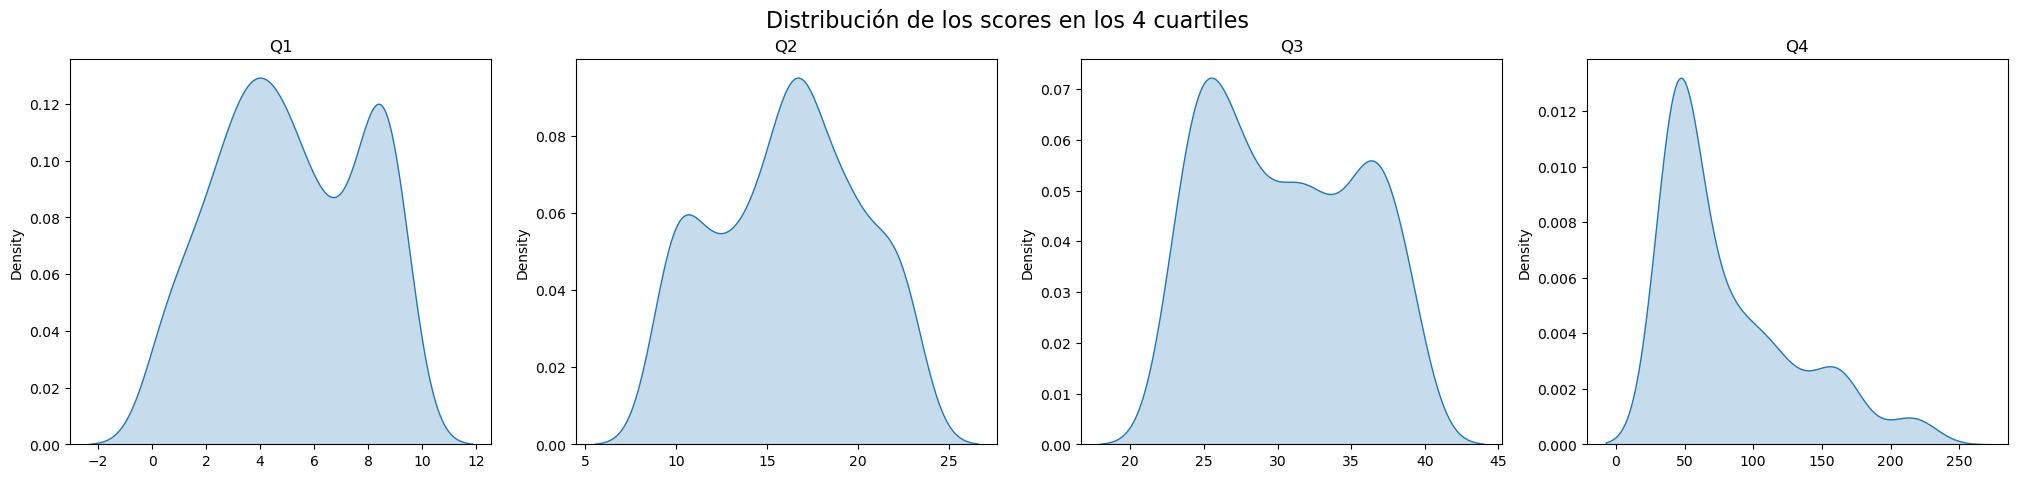

In [258]:
def plot_scores(q_scores):
    fig, axs = plt.subplots(1, 4, figsize=(25,5))

    sns.kdeplot(q_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_scores[3], ax=axs[3], label="Q4", fill=True)

    axs[0].set_title("Q1")
    axs[1].set_title("Q2")
    axs[2].set_title("Q3")
    axs[3].set_title("Q4")

    plt.suptitle("Distribución de los scores en los 4 cuartiles", fontsize=16)

    plt.show()

plot_scores(q_scores)

A continuación, representamos un gráfico similar, esta vez mostrando las densidades de los valores de penalización y recompensa utilizados por la población de alineadores en la última iteración del algoritmo genético.

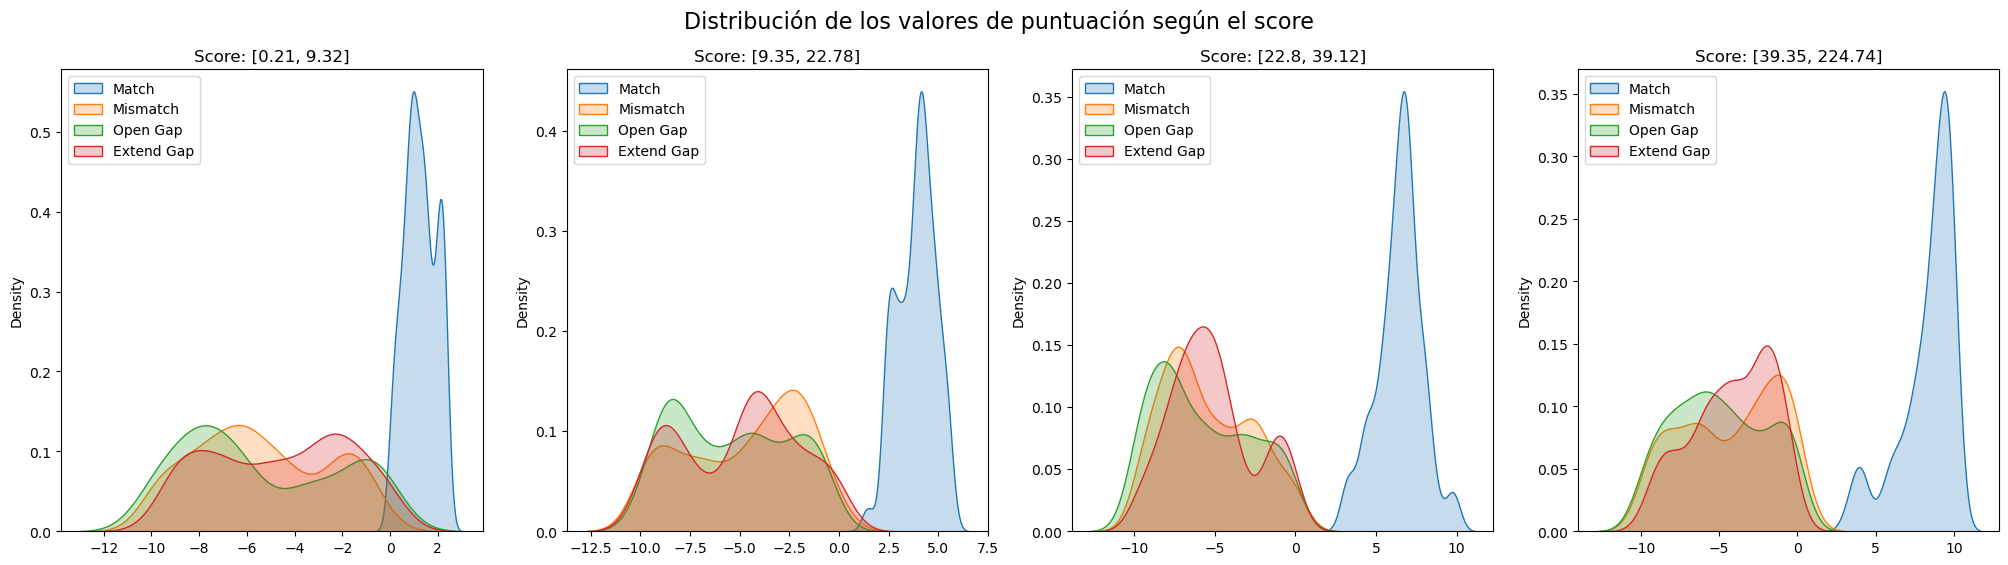

In [259]:
def plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores):
    fig, axs = plt.subplots(1, 4, figsize=(25,6))

    sns.kdeplot(q_match_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_mismatch_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_open_gap_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_extend_gap_scores[0], ax=axs[0], label="Q1", fill=True)

    sns.kdeplot(q_match_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_mismatch_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_open_gap_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_extend_gap_scores[1], ax=axs[1], label="Q2", fill=True)

    sns.kdeplot(q_match_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_mismatch_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_open_gap_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_extend_gap_scores[2], ax=axs[2], label="Q3", fill=True)

    sns.kdeplot(q_match_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_mismatch_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_open_gap_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_extend_gap_scores[3], ax=axs[3], label="Q4", fill=True)

    axs[0].set_title(f"Score: [{round(min(q_scores[0]), 2)}, {round(max(q_scores[0]), 2)}]")
    axs[1].set_title(f"Score: [{round(min(q_scores[1]), 2)}, {round(max(q_scores[1]), 2)}]")
    axs[2].set_title(f"Score: [{round(min(q_scores[2]), 2)}, {round(max(q_scores[2]), 2)}]")
    axs[3].set_title(f"Score: [{round(min(q_scores[3]), 2)}, {round(max(q_scores[3]), 2)}]")

    axs[0].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[1].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[2].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[3].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")

    plt.suptitle("Distribución de los valores de puntuación según el score", fontsize=16)

    plt.show()

plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores)

Y ahora bien, ¿cuántas coincidencias ocurrirán en cada percentil?

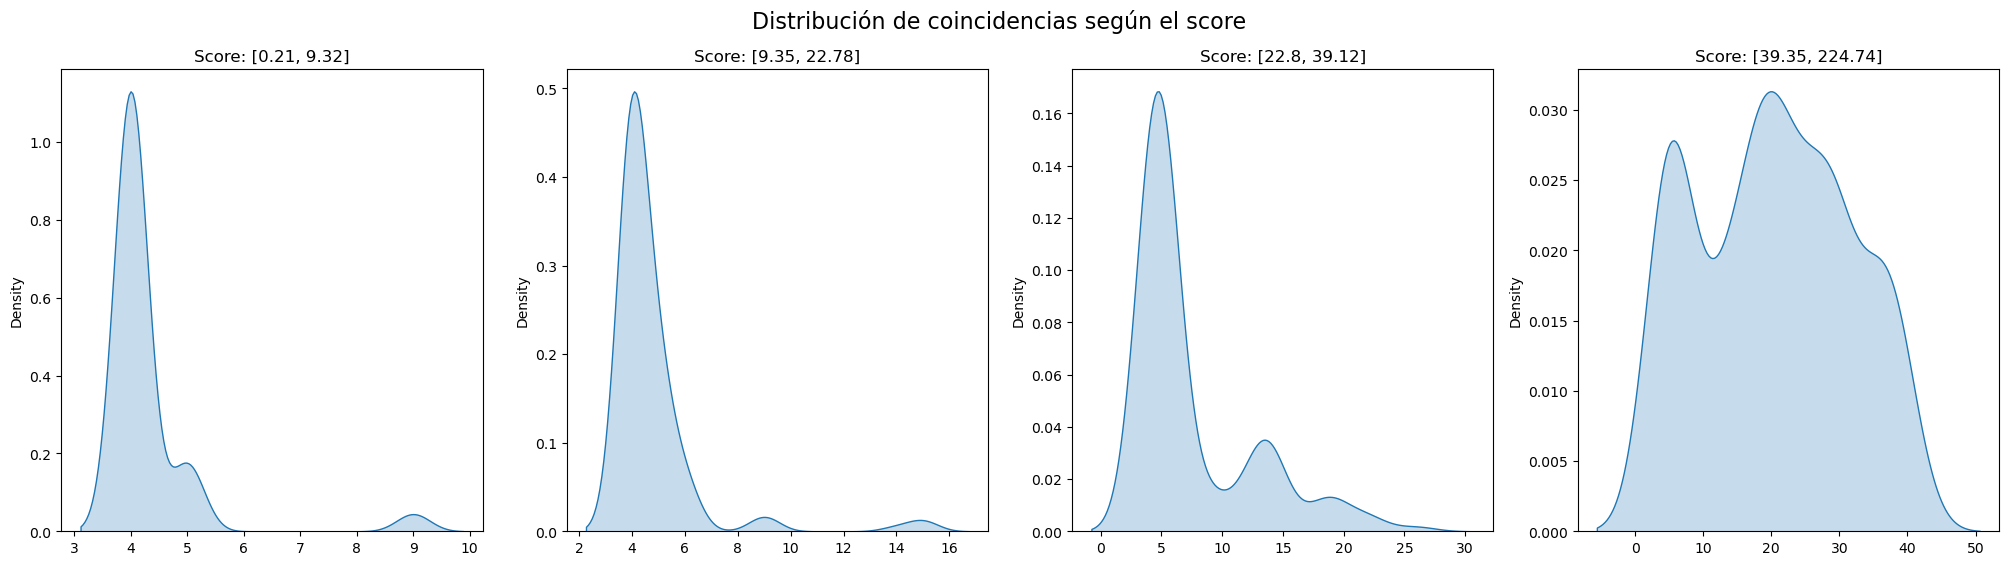

In [260]:
def plot_matches(q_scores, q_matches):
    fig, axs = plt.subplots(1, 4, figsize=(25,6))

    sns.kdeplot(q_matches[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_matches[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_matches[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_matches[3], ax=axs[3], label="Q4", fill=True)
    
    axs[0].set_title(f"Score: [{round(min(q_scores[0]), 2)}, {round(max(q_scores[0]), 2)}]")
    axs[1].set_title(f"Score: [{round(min(q_scores[1]), 2)}, {round(max(q_scores[1]), 2)}]")
    axs[2].set_title(f"Score: [{round(min(q_scores[2]), 2)}, {round(max(q_scores[2]), 2)}]")
    axs[3].set_title(f"Score: [{round(min(q_scores[3]), 2)}, {round(max(q_scores[3]), 2)}]")

    plt.suptitle("Distribución de coincidencias según el score", fontsize=16)

    plt.show()

plot_matches(q_scores, q_matches)

Con esta gráfica podemos ver cómo, a mayor es el score, mayor es el número de coincidencias si la función de fitness viene dada por el número de coincidencias.

### Alineamiento de secuencias con matriz de puntuación

Las matrices de puntuación son una forma de representar las penalizaciones y recompensas de un alineamiento de secuencias. Gracias a ellas, podemos expresar de forma más compacta y general las reglas de alineamiento, utilizando una matriz de puntuación predefinida.

In [155]:
aligner = AlignerBuilder().build()

Haremos uso de las siguientes matrices de puntuación para realizar el alineamiento de las secuencias generadas anteriormente:

In [212]:
def plot_matrix(ax, matrix, title="Matrix"):
    sns.heatmap(matrix, annot=False, ax=ax)
    ax.set_title(title)

    aminos = matrix.alphabet
    ax.set_xticks(ticks=np.arange(len(aminos)) + 0.5, labels=aminos, ha='center', rotation=0)
    ax.set_yticks(ticks=np.arange(len(aminos)) + 0.5, labels=aminos, rotation=0, va='center')

    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=0)
    ax.tick_params(axis='y', length=0)

def plot_from_name(axs, name):
    matrix = substitution_matrices.load(name)
    plot_matrix(axs, matrix, title=name)

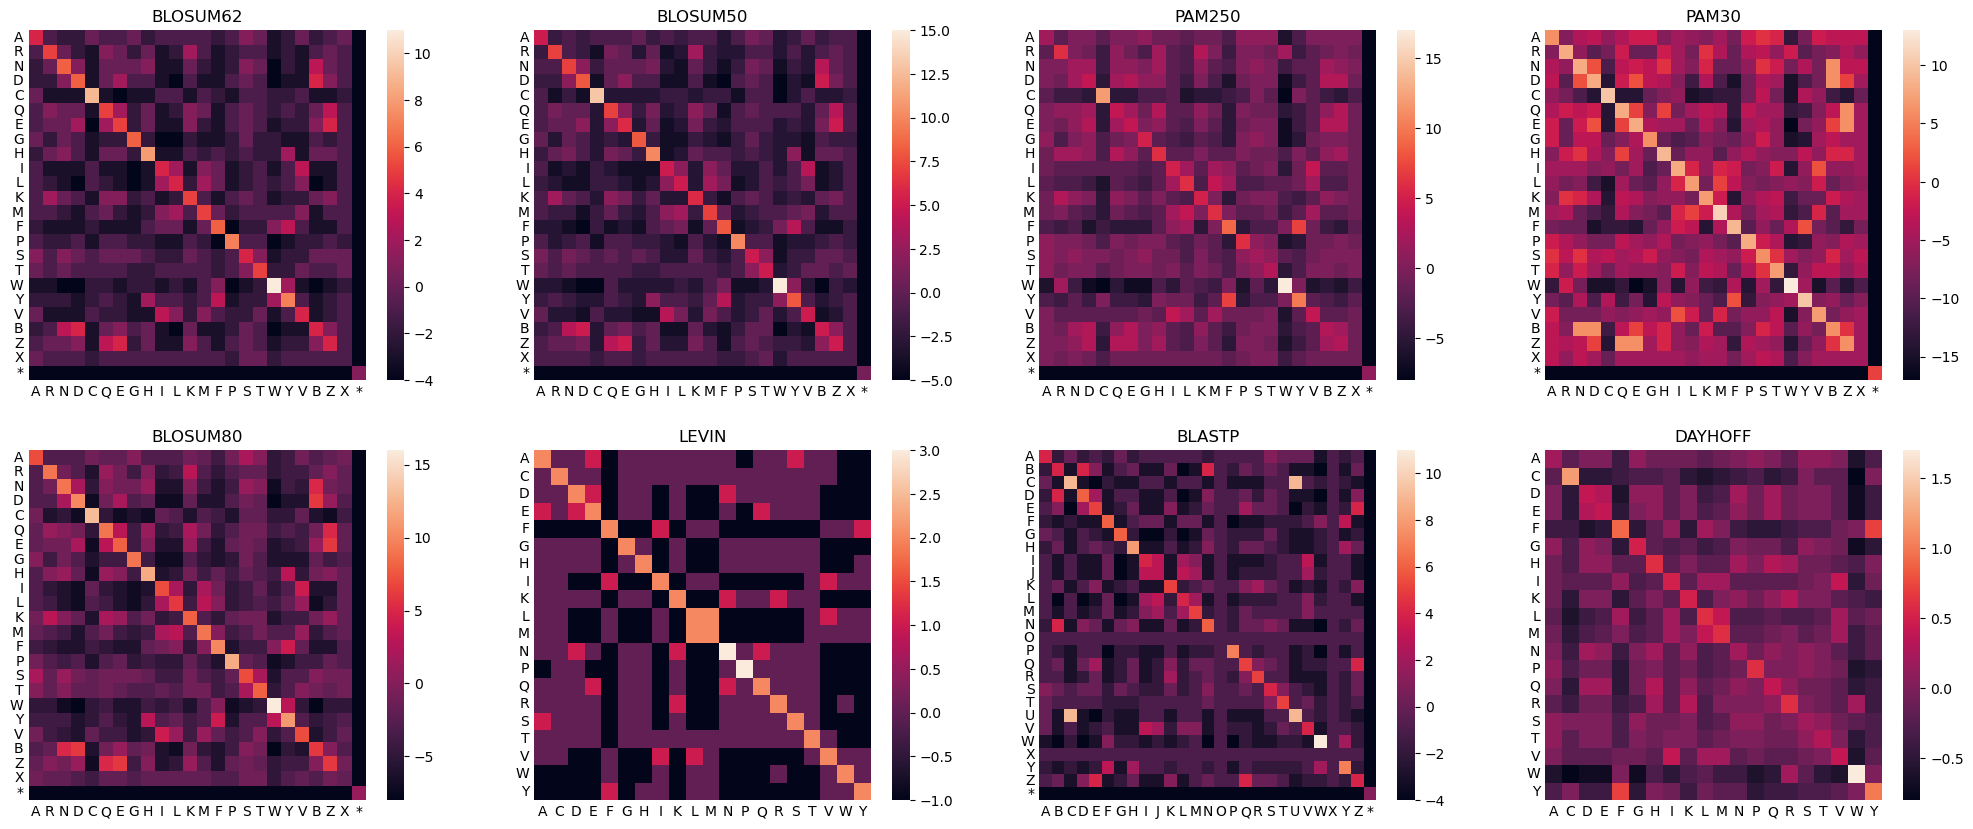

In [214]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

plot_from_name(axs[0][0], "BLOSUM62")
plot_from_name(axs[0][1], "BLOSUM50")
plot_from_name(axs[0][2], "PAM250")
plot_from_name(axs[0][3], "PAM30")
plot_from_name(axs[1][0], "BLOSUM80")
plot_from_name(axs[1][1], "LEVIN")
plot_from_name(axs[1][2], "BLASTP")
plot_from_name(axs[1][3], "DAYHOFF")

plt.show()

Las matrices nos dicen cuánto se penaliza o se recompensa en el alineamiento cada vez que se produce una coincidencia o sustitución de aminoácidos. Esto es realmente útil, pues debido a las propiedades bioquímicas de los mismos, puede tener más o menos sentido que en la naturaleza se de o no una sustitución.

- Para la matriz de puntuación BLOSUM62

La matriz de puntuación BLOSUM62 es una matriz de sustitución de aminoácidos que se utiliza para alinear secuencias de proteínas. Esta matriz se utiliza para asignar un puntaje a cada par de aminoácidos, de acuerdo a la probabilidad de que ocurra la sustitución de un aminoácido por otro en la evolución de las secuencias. Concretamente, BLOSUM62 se basa en bloques de alineamientos locales de secuencias de proteínas altamente conservadas (o sin gap) con un nivel de identidad del 62%.

En la matriz, los puntajes positivos indican que la sustitución de un aminoácido por otro es más probable de lo esperado al azar, lo que refleja que esos aminoácidos tienden a reemplazarse entre sí debido a propiedades químicas o funcionales similares. Por otro lado, los puntajes negativos indican que la sustitución es menos probable de lo esperado al azar, lo que implica que esos aminoácidos no suelen intercambiarse en la evolución.

In [189]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum62")

In [190]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 16
Score: 115.0
Alignment:
target            0 CE---VG-E-S--TS-H--V----HSII-ES-W---NKNAMMGVMLQCQVAETYHFGTQS
                  0 ||---|--.-|--|--|--.----|----.--|---||-------------|----|---
query             2 CEYWSV-IDFSSET-CHFNMDWARH---KD-GWYSVNK-------------E----G---

target           41 WQCFLE-WPY 50
                 60 ||-----|-| 70
query            36 WQ----RW-Y 41



- Para la matriz de puntuación BLOSUM50

La principal diferencia entre BLOSUM50 y BLOSUM62 radica en el nivel de conservación de las secuencias utilizadas para construirlas: BLOSUM50 se basa en alineamientos de secuencias con un 50% de identidad o menos, mientras que BLOSUM62 usa un 62% o menos, lo que hace que BLOSUM50 sea más adecuada para detectar similitudes entre secuencias más divergentes y con mayor distancia evolutiva. Esto también implica que BLOSUM50 es menos estricta y más sensible a relaciones evolutivas profundas, mientras que BLOSUM62 está optimizada para secuencias de divergencia moderada, siendo más específica para encontrar similitudes en secuencias más cercanas.

In [ ]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum50")

In [ ]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 153.0
Alignment:
target            2 FC--------EGI-D-P--DQRF-GSGEWFAFQGPQP-IGTNMG-DTP--WDNTGY-WSL
                  0 .---------|-|-.-|--.-|--|---|-----|.--|------|----||||---|..
query             7 Y-HNHMDPIVE-IANWPWWN-R-VG---W-----PR-DI-----FD--ENWDNT--KWTM

target           44 --W 45
                 60 --| 63
query            45 GQW 48



- Para la matriz de puntuación PAM250

La matriz de puntuación PAM250 (Point Accepted Mutation 250) es una matriz de sustitución de aminoácidos utilizada para alinear secuencias de proteínas. Esta matriz se utiliza para asignar puntajes a cada par de aminoácidos, en función de la probabilidad de que un aminoácido sea sustituido por otro a lo largo del tiempo evolutivo. Concretamente, PAM250 se basa en el modelo de sustitución evolutiva que representa una distancia evolutiva acumulada en la que han ocurrido 250 mutaciones aceptadas por cada 100 residuos en promedio entre las secuencias analizadas.

Características clave de PAM250:

- Distancia evolutiva mayor: PAM250 está diseñada para detectar relaciones entre secuencias que han divergido hace mucho tiempo, es decir, secuencias más distantes en términos evolutivos. Es menos adecuada para secuencias altamente conservadas o de corta divergencia.

- Mutaciones aceptadas: Se basa en la idea de "mutaciones aceptadas", es decir, cambios en aminoácidos que han ocurrido y se han mantenido funcionales en la evolución de las proteínas.

- Construcción: Se derivó al observar las tasas de sustitución entre pares de aminoácidos en familias de proteínas conservadas y luego extrapolando estas tasas para reflejar 250 mutaciones por cada 100 residuos promedio.

In [18]:
alignments = aligner.align(sequence1, sequence2, matrix="pam250")

In [19]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 13
Score: 139.0
Alignment:
target            0 G--G-FC----EG-I-D----P--DQRF-GSGEWFAFQGP-QPIGT-NMGDTP-WDNTGY
                  0 .--.-.-----.--|-.----|--.-|--|---|-----|-.-|---.--.---||||--
query             2 AHQDVY-HNHMD-PIVEIANWPWWN-R-VG---W-----PRD-I--FD--E--NWDNT--

target           41 -WSL--W 45
                 60 -|..--| 67
query            41 KWTMGQW 48



- Para la matriz de puntuación pam30

La principal diferencia entre PAM250 y PAM30 radica en la distancia evolutiva que representan: PAM250 se utiliza para analizar secuencias con alta divergencia evolutiva, ya que modela 250 mutaciones aceptadas por cada 100 residuos, mientras que PAM30 está diseñada para secuencias más cercanas en términos evolutivos, representando solo 30 mutaciones aceptadas por cada 100 residuos. Esto implica que PAM250 es más adecuada para detectar relaciones entre secuencias distantes, siendo menos estricta y asignando puntajes más bajos a sustituciones no conservadoras, mientras que PAM30 es mucho más estricta, asignando puntajes más altos a las coincidencias exactas y penalizando fuertemente las sustituciones y los gaps, lo que la hace ideal para alineamientos de secuencias conservadas o muy similares.

In [ ]:
alignments = aligner.align(sequence1, sequence2, matrix="pam30")

In [ ]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 144.0
Alignment:
target            2 FC--------EGI-D-P--DQRF-GSGEWFAFQGPQP--IGTNMG-DTP--WDNTGY-WS
                  0 .---------|-|-.-|--.-|--|---|-----|----|------|----||||---|-
query             7 Y-HNHMDPIVE-IANWPWWN-R-VG---W-----P--RDI-----FD--ENWDNT--KW-

target           43 -L--W 45
                 60 -.--| 65
query            43 TMGQW 48



- Para la matriz de puntuación BLOSUM80

Análogamente a la matriz anterior, la principal diferencia de BLOSUM80 con respecto a BLOSUM62 es que BLOSUM80 se construye a partir de alineamientos de secuencias con un 80% de identidad o menos, lo que la hace más adecuada para identificar similitudes en secuencias altamente conservadas o con menor distancia evolutiva. Esto significa que BLOSUM80 es más estricta que BLOSUM62, asignando puntajes más altos a sustituciones entre aminoácidos muy similares y penalizando más las sustituciones no conservadoras. Por tanto, BLOSUM80 es ideal para detectar relaciones en secuencias cercanas, donde los cambios aceptables son mínimos y se necesita mayor especificidad.

In [22]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum80")

In [23]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 179.0
Alignment:
target            2 FC--------EGI-D-P--DQRF-GSGEWFAFQGPQP-IGTNMG-DTP--WDNTGY-WSL
                  0 .---------|-|-.-|--.-|--|---|-----|.--|------|----||||---|..
query             7 Y-HNHMDPIVE-IANWPWWN-R-VG---W-----PR-DI-----FD--ENWDNT--KWTM

target           44 --W 45
                 60 --| 63
query            45 GQW 48



- Para la matriz LEVIN

La matriz de puntuación LEVIN es una matriz de sustitución de aminoácidos que se utiliza para alinear secuencias de proteínas. Esta matriz se basa en la idea de que las sustituciones de aminoácidos en secuencias de proteínas pueden ser modeladas por un modelo de evolución de Markov, que describe la probabilidad de que un aminoácido sea reemplazado por otro a lo largo del tiempo evolutivo. La matriz LEVIN se construye a partir de un modelo de evolución de Markov que considera las propiedades bioquímicas y estructurales de los aminoácidos, así como la frecuencia de sustituciones observadas en secuencias de proteínas.

In [191]:
alignments = aligner.align(sequence1, sequence2, matrix="levin")

In [192]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 16
Score: 39.0
Alignment:
target            0 CE---VG-E-STS---HVHSII--E-S-----W---NKNAMMGVML-QCQVAET--YHFG
                  0 ||---|--.-|-|---|---.---.-.-----|---||-.--|----|--------||--
query             2 CEYWSV-IDFS-SETCH---F-NMDWARHKDGWYSVNK-E--G---WQ------RWYH--

target           38 TQSW---QCF-LE 47
                 60 --|----|---|. 73
query            42 --S-YMIQ--HLA 50



- Para la matriz BLASTP

La matriz de puntuación BLASTP es una matriz de sustitución de aminoácidos que se utiliza en el algoritmo BLAST (Basic Local Alignment Search Tool) para alinear secuencias de proteínas y buscar similitudes entre ellas. Esta matriz se basa en la idea de que las sustituciones de aminoácidos en secuencias de proteínas pueden ser modeladas por un modelo de evolución de Markov, que describe la probabilidad de que un aminoácido sea reemplazado por otro a lo largo del tiempo evolutivo. La matriz BLASTP se construye a partir de un modelo de evolución de Markov que considera las propiedades bioquímicas y estructurales de los aminoácidos, así como la frecuencia de sustituciones observadas en secuencias de proteínas.

In [193]:
alignments = aligner.align(sequence1, sequence2, matrix="blastp")

In [194]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 16
Score: 115.0
Alignment:
target            0 CE---VG-E-S--TS-H--V----HSII-ES-W---NKNAMMGVMLQCQVAETYHFGTQS
                  0 ||---|--.-|--|--|--.----|----.--|---||-------------|----|---
query             2 CEYWSV-IDFSSET-CHFNMDWARH---KD-GWYSVNK-------------E----G---

target           41 WQCFLE-WPY 50
                 60 ||-----|-| 70
query            36 WQ----RW-Y 41



- Para la matriz DAYHOFF

La matriz de puntuación DAYHOFF es una matriz de sustitución de aminoácidos que se utiliza para alinear secuencias de proteínas. Esta matriz se basa en la idea de que las sustituciones de aminoácidos en secuencias de proteínas pueden ser modeladas por un modelo de evolución de Markov, que describe la probabilidad de que un aminoácido sea reemplazado por otro a lo largo del tiempo evolutivo. La matriz DAYHOFF se construye a partir de un modelo de evolución de Markov que considera las propiedades bioquímicas y estructurales de los aminoácidos, así como la frecuencia de sustituciones observadas en secuencias de proteínas.

In [196]:
alignments = aligner.align(sequence1, sequence2, matrix="dayhoff")

In [197]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 13.799999999999999
Alignment:
target            0 CE---VG-E-S--TS-HV-HSIIESW--NKNAMMGVMLQCQVAET-Y--HF--GTQSWQC
                  0 ||---|--.-|--|--|--.-.-.-|--.|.---|-----------|--.---|---||-
query             2 CEYWSV-IDFSSET-CH-FN-M-D-WARHKD---G----------WYSVN-KEG---WQ-

target           44 FLE-W--PY 50
                 60 ----|--.| 69
query            38 ---RWYHSY 44



- Para una matriz personalizada

Uno podría definir una matriz de puntuación personalizada para adaptarse a un problema específico o a un conjunto de datos particular. Por ejemplo, si se tiene información previa sobre las propiedades de los aminoácidos o las relaciones entre ellos, se podría diseñar una matriz de puntuación que refleje esas características específicas. Esto permitiría ajustar el alineamiento de las secuencias para que refleje mejor las similitudes y diferencias relevantes en el contexto del problema en cuestión.

A continuación, cogeremos una matriz ya diseñada, la BLOSUM50, y alinearemos las dos secuencias generadas anteriormente.

In [41]:
blosum50 = substitution_matrices.load("BLOSUM50")

Si visualizamos la matriz original, 

In [26]:
blosum50[('A', 'R')] = -1
blosum50[('R', 'A')] = -1
blosum50[('A', 'A')] = 5
blosum50[('R', 'R')] = 5
blosum50[('A', 'M')] = -4
blosum50[('M', 'A')] = -3

In [27]:
alignments = aligner.align(sequence1, sequence2, matrix=blosum50)

In [28]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 144.0
Alignment:
target            2 FC--------EGI-D-P--DQRF-GSGEWFAFQGPQP--IGTNMG-DTP--WDNTGY-WS
                  0 .---------|-|-.-|--.-|--|---|-----|----|------|----||||---|-
query             7 Y-HNHMDPIVE-IANWPWWN-R-VG---W-----P--RDI-----FD--ENWDNT--KW-

target           43 -L--W 45
                 60 -.--| 65
query            43 TMGQW 48



Por último, cargamos una matriz personalizada directamente desde un archivo, y alineamos las dos secuencias generadas anteriormente.

In [205]:
matrix = substitution_matrices.read("./data/MATRIX")

Esta matriz se corresponde con la matrix DAYHOFF, auqnue se han modificados todos los elementos de la diagonal inversa para que su puntuación sea muy cercana a 1. Si lo visualizamos,

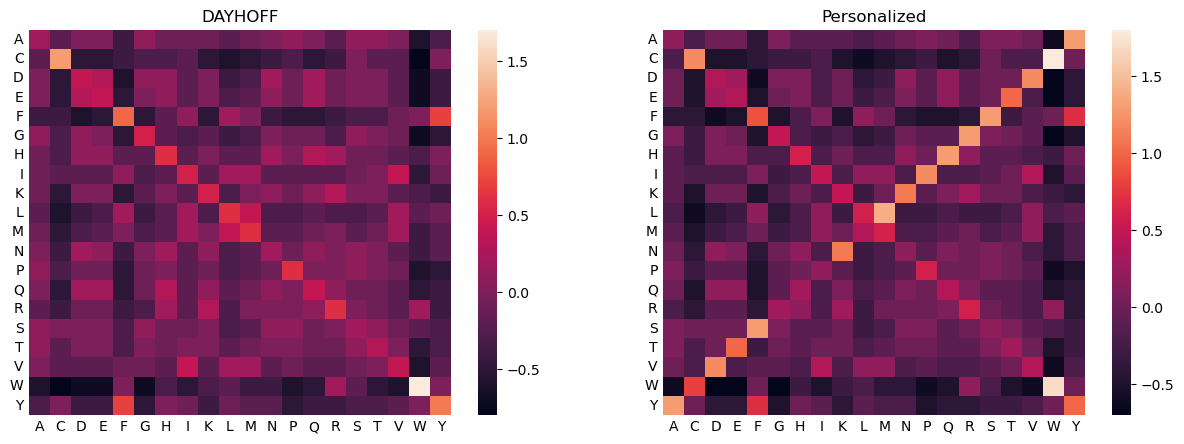

In [215]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_from_name(axs[0], "DAYHOFF")
plot_matrix(axs[1], matrix, title="Personalized")

plt.show()

Si alineamos, obtenemos lo siguiente:

In [208]:
alignments = aligner.align(sequence1, sequence2, matrix=matrix)

In [209]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 15
Score: 13.799999999999999
Alignment:
target            0 CE---VG-E-S--TS-HV-HSIIESW--NKNAMMGVMLQCQVAET-Y--HF--GTQSWQC
                  0 ||---|--.-|--|--|--.-.-.-|--.|.---|-----------|--.---|---||-
query             2 CEYWSV-IDFSSET-CH-FN-M-D-WARHKD---G----------WYSVN-KEG---WQ-

target           44 FLE-W--PY 50
                 60 ----|--.| 69
query            38 ---RWYHSY 44



Obtenemos el mismo número de matches, pero un score menor.

## Descarga de ficheros FASTA

A continuación, se descargan secuencias de aminoacidos correspondientes a distintas proteínas de la base de datos de NCBI. Para ello, haremos uso de un `DataLoader`, del que ya se disponía de una versión previamente implementada en la práctica anterior.

In [261]:
sequenceLoader = DataLoaderFactory.get_loader("api")

In [262]:
sequence1 = sequenceLoader.load(('ABG47031.1',))[0].seq
sequence2 = sequenceLoader.load(('AUJ50941.1',))[0].seq

print(f"Sequence 1: {sequence1}")
print(f"Sequence 2: {sequence2}")

Sequence 1: MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFR
Sequence 2: MKYNEINNEGVEKLMDIFYAKIRTHEQLGPIFNGAVGIDDASWERHKEKIAKFWKTMLLNENLYMGNPVQPHINLLPFDIKLFDVWLDLFKECLDQVFEEKASEHFYEVACNIAKNFKAVLFQQ


### Alineamiento de secuencias con algoritmo genético

In [263]:
geneticAlgorithm = GeneticAlgorithm(1400, 20, sequence1, sequence2, fitness_function)
aligners, best_aligner = geneticAlgorithm.run()

In [264]:
print(best_aligner.args())

AlignerArgs(match_score=7.661261834717986, 
                    mismatch_score=-6.869362838850453, 
                    target_internal_open_gap_score=-2.9178329168870585, 
                    target_internal_extend_gap_score=-0.6885268060498273, 
                    target_left_open_gap_score=-4.278850397440683, 
                    target_left_extend_gap_score=-6.133244478779524, 
                    target_right_open_gap_score=-0.9121834735144752, 
                    target_right_extend_gap_score=-8.197145481323806, 
                    query_internal_open_gap_score=-0.40783499945297286, 
                    query_internal_extend_gap_score=-6.208200685036682, 
                    query_left_open_gap_score=-4.210017285331078, 
                    query_left_extend_gap_score=-3.1752641655575187, 
                    query_right_open_gap_score=-7.834538632313316, 
                    query_right_extend_gap_score=-3.4800609072282818)


In [265]:
alignment = best_aligner.align(sequence1, sequence2)

for alignment in alignment:
    print(f"Alignment: {alignment[0]}")
    print(f"Alignment: {alignment[1]}")
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    break

Alignment: K----VNV-DEVG-GE-------AL--GR----LL-------VVY------PWT-QRF--FE----SFG-----DLS-T-P-D-A-VMGNPKVK--AHG-K-K-VLG-AFSD--GLA----HLDNL-KG------TF---ATLSELH-----C------DK--L
Alignment: KYNEI-N-N-E-GV-EKLMDIFYA-KI-RTHEQ-LGPIFNGA-V-GIDDAS-W-E-R-HK-EKIAK-F-WKTML-L-N-E-N-L-Y-MGNP-V-QP-H-I-N-L-L-P-F-DIK-L-FDVW-LD-LFK-ECLDQV-FEEKA--SE-HFYEVACNIAKNF-KAVL
Matches: 36
Score: 127.34488535503061


Veamos ahora, al igual que hicimos antes, cómo son los elementos de la población en la última iteración del algoritmo genético.

In [266]:
match_scores = []
matches = []
mismatch_scores = []
open_gap_scores = []
extend_gap_scores = []
scores = []

for aligner in aligners:
    alignment = aligner.align(sequence1, sequence2)[0]

    match_scores.append(aligner.args().match_score)
    mismatch_scores.append(aligner.args().mismatch_score)
    open_gap_scores.append(aligner.args().target_internal_open_gap_score)
    extend_gap_scores.append(aligner.args().target_internal_extend_gap_score)

    scores.append(alignment.score)
    matches.append(get_matches(alignment))

In [267]:
scores = np.array(scores)
match_scores = np.array(match_scores)
mismatch_scores = np.array(mismatch_scores)
open_gap_scores = np.array(open_gap_scores)
extend_gap_scores = np.array(extend_gap_scores)
matches = np.array(matches)

quartiles = np.percentile(scores, [25, 50, 75])

print(f"Los scores se pueden dividir en los siguientes 4 cuartiles:")
print(f"Q1: {quartiles[0]} - Q2: {quartiles[1]} - Q3: {quartiles[2]}")

Los scores se pueden dividir en los siguientes 4 cuartiles:
Q1: 10.796874086308708 - Q2: 26.563855108944697 - Q3: 38.91781431374921


In [268]:
q_scores, q_matches, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores = get_quartiles()

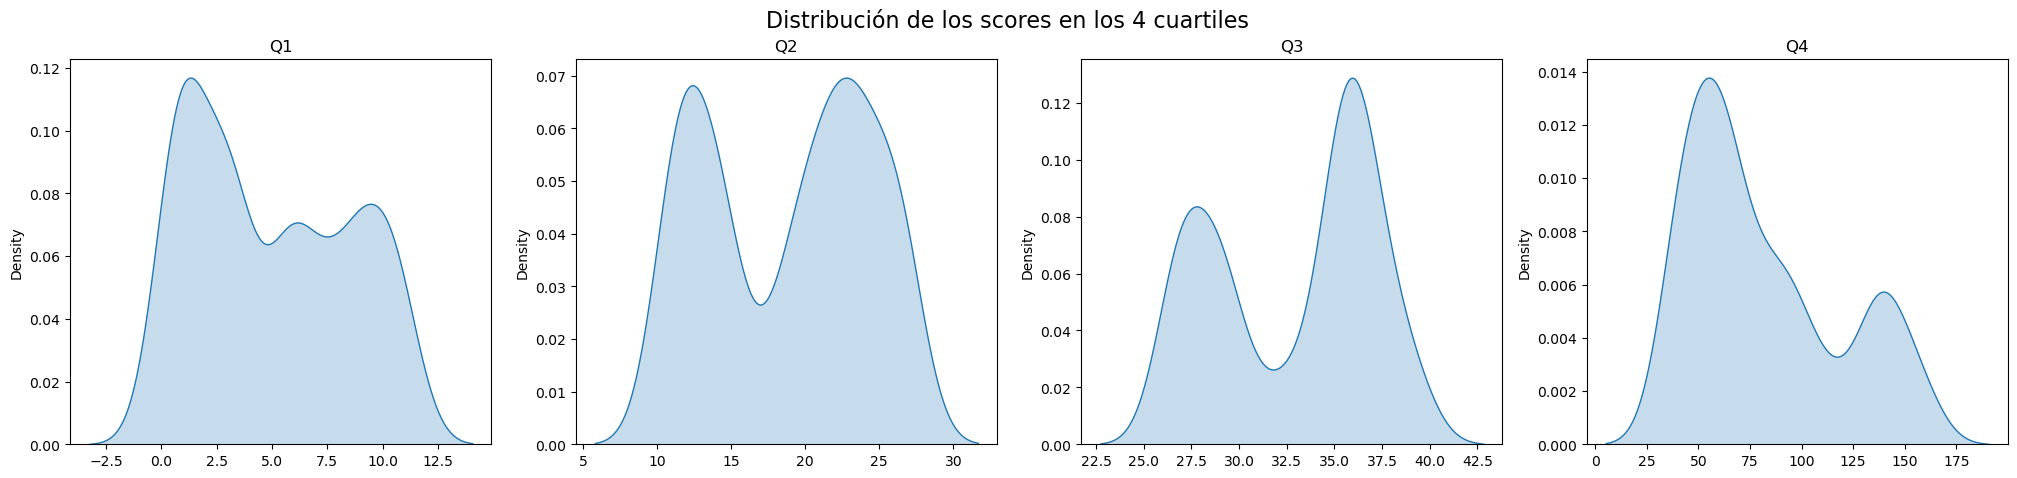

In [269]:
plot_scores(q_scores)

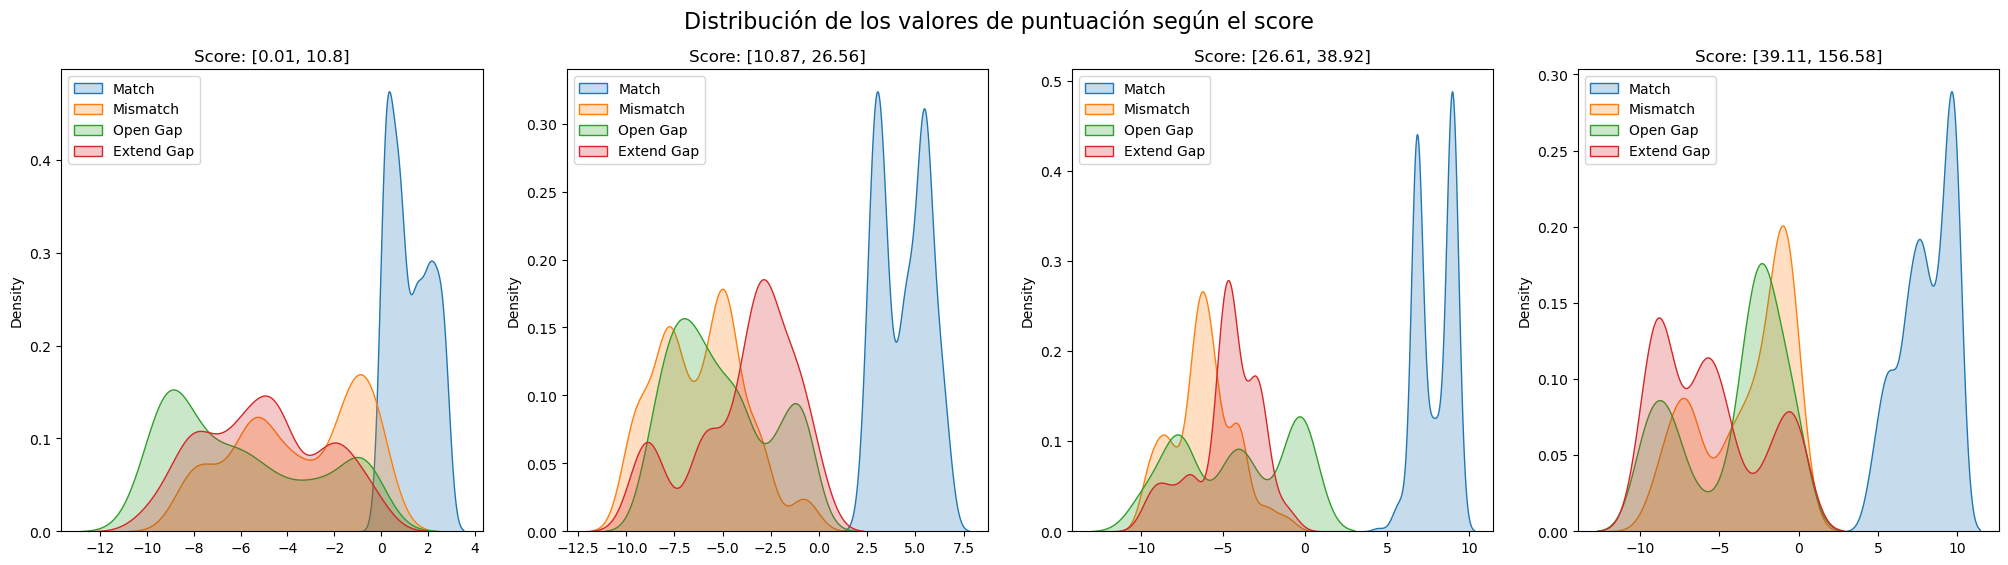

In [270]:
plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores)

Como es evitende, al ser la función de fitness el número de coincidencias, el `match_score` suele tomarse positivo, mientras que el resto de valores suelen ser negativos. Podemos ver como, a mayor score, mayor es el `match_score` asociado al alineador, mientras que las penalizaciónes suelen mantenerse en el mismo rango.

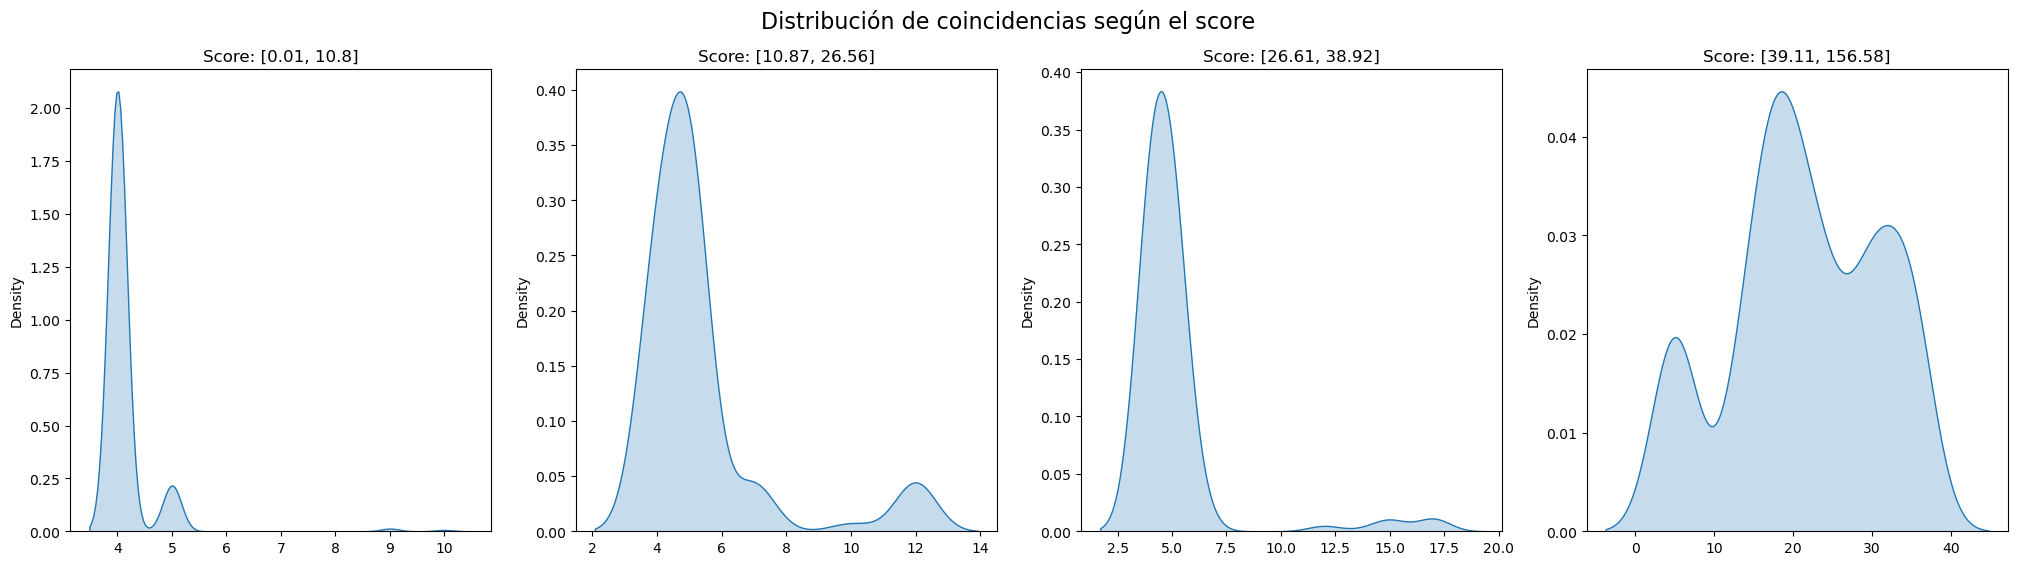

In [271]:
plot_matches(q_scores, q_matches)

### Alineamiento de secuencias con matriz de puntuación

In [224]:
aligner = AlignerBuilder().build()

Para este apartado, volveremos a utilizar las matrices de puntuación BLOSUM62, BLOSUM50, PAM250, PAM30, BLOSUM80, LEVIN, BLASTP, DAYHOFF y una matriz personalizada.

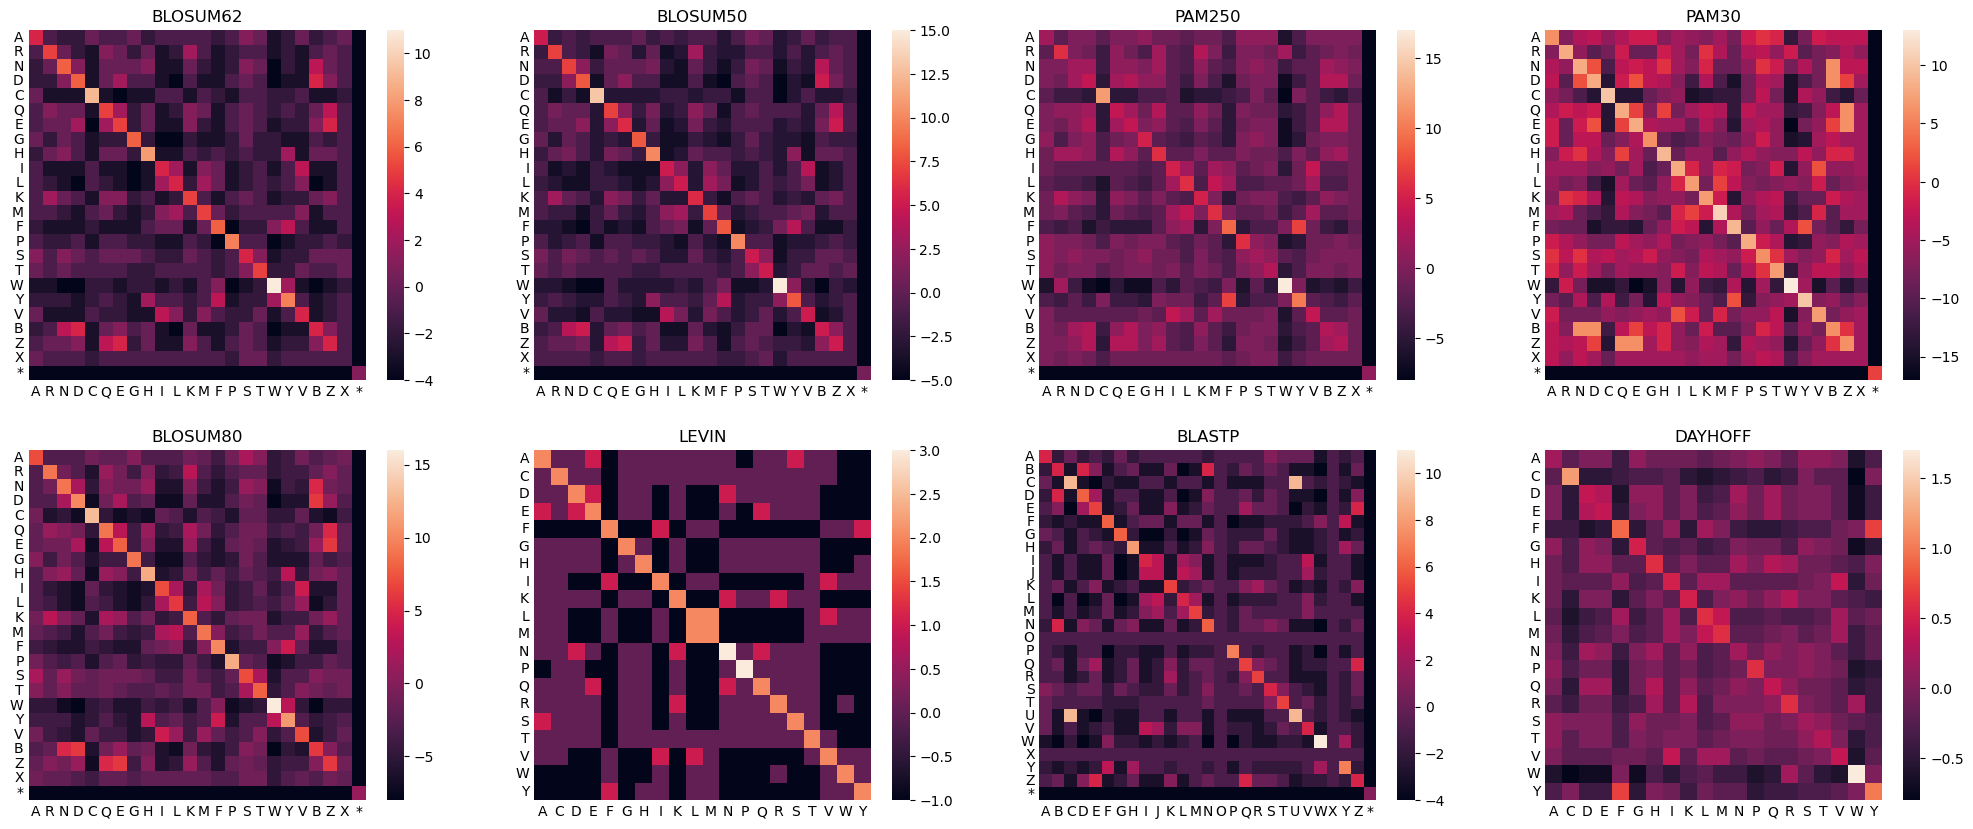

In [216]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

plot_from_name(axs[0][0], "BLOSUM62")
plot_from_name(axs[0][1], "BLOSUM50")
plot_from_name(axs[0][2], "PAM250")
plot_from_name(axs[0][3], "PAM30")
plot_from_name(axs[1][0], "BLOSUM80")
plot_from_name(axs[1][1], "LEVIN")
plot_from_name(axs[1][2], "BLASTP")
plot_from_name(axs[1][3], "DAYHOFF")

plt.show()

- Para la matriz de puntuación BLOSUM62

In [225]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum62")

In [226]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 40
Score: 248.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP----DA-V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|-----.--.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLNE-NLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz de puntuación BLOSUM50

In [227]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum50")

In [228]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 40
Score: 318.0
Alignment:
target            0 M----VHLTP-E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |----..----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 MKYNEIN---NEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGD----L-STPDA-V-MGNPKVKA-HGKKV-LGA--FSDG--LAH
                 60 -|-.|----|--.-|------|-.--.--.-||||-|.--|---.-|----|-|---|--
query            41 SW-ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQ-PH---INL--LPF-D-IKL--

target           78 ----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 ----||-|-|--------|---|--||-|-----|.--|------||. 168
query            82 FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz de puntuación PAM250

In [229]:
alignments = aligner.align(sequence1, sequence2, matrix="pam250")

In [230]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 38
Score: 267.0
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123



- Para la matriz de puntuación pam30

In [232]:
alignments = aligner.align(sequence1, sequence2, matrix="pam30")

In [233]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 41
Score: 335.0
Alignment:
target            0 M----VHLTP--E--EKS------A-V-TA---LWGK-V-N--V--D----EVGG---E-
                  0 |----.------|--||-------|-.-|----|-|--.-|--|--|----|------|-
query             0 MKYNEI----NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFNGAVGIDDASWE---RHKEK

target           27 -ALGRLLVV-YPW-TQRFF----ESFGDLSTPDAV-MGNPKVKA--HGKKV-LGA--FSD
                 60 -|--------.-|-|--------|---.|-------||||-|----|---.-|----|-|
query            49 IA-------KF-WKT----MLLNE---NL------YMGNP-V--QPH---INL--LPF-D

target           74 G--LAH----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENF 104
                120 ---|------||-|-|--------|---|--||-|-----|.--|------|| 173
query            79 -IKL--FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NF 117



- Para la matriz de puntuación BLOSUM80

In [234]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum80")

In [235]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 40
Score: 389.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP---DA--V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|----.---.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLN-ENLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz LEVIN

In [236]:
alignments = aligner.align(sequence1, sequence2, matrix="levin")

In [237]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 39
Score: 99.0
Alignment:
target            0 M----VHLTP--E--EKS------A-V-T-A-LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |----.------|--||-------|-.-|-.-|-|--.-|----|--|.|---.------
query             0 MKYNEI----NNEGVEK-LMDIFYAKIRTHEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP---DA-V-MGNPKVKA--HG-KKVLGA-FSDG--LAH
                 60 -|-.|----|--.-|------|----..-.-||||-|----|--.-.|---|-|---|--
query            41 SW-ER--HKEKIAKF----WKT-MLLNENLYMGNP-V--QPH-IN-LL--PF-D-IKL--

target           78 ----LDNL-KGT------F---ATLSELHC--DKLHV--DP-E-NFR 105
                120 ----||-|-|--------|---|--||-|---.---|--.--.-||. 167
query            82 FDVWLD-LFK--ECLDQVFEEKA--SE-H-FYE---VACN-IAKNFK 118



- Para la matriz BLASTP

In [238]:
alignments = aligner.align(sequence1, sequence2, matrix="blastp")

In [239]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 40
Score: 248.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP----DA-V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|-----.--.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLNE-NLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz DAYHOFF

In [240]:
alignments = aligner.align(sequence1, sequence2, matrix="dayhoff")

In [241]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 38
Score: 26.699999999999996
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123



- Para una matriz personalizada

Cargamos una matriz personalizada directamente desde un archivo, y alineamos las dos secuencias generadas anteriormente.

In [ ]:
matrix = substitution_matrices.read("./data/MATRIX")

In [244]:
alignments = aligner.align(sequence1, sequence2, matrix=matrix)

In [245]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 38
Score: 26.699999999999996
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123

